In [1]:
!pip install boto3
!pip install s3fs
!pip install cassandra-driver

     |████████████████████████████████| 7.2 MB 75 kB/s eta 0:00:012
  Attempting uninstall: botocore
    Found existing installation: botocore 1.17.44
    Uninstalling botocore-1.17.44:
      Successfully uninstalled botocore-1.17.44
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

aiobotocore 1.1.2 requires botocore<1.17.45,>=1.17.44, but you'll have botocore 1.19.51 which is incompatible.
     |████████████████████████████████| 6.5 MB 484 kB/s eta 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.19.51
    Uninstalling botocore-1.19.51:
      Successfully uninstalled botocore-1.19.51
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the 

In [19]:
!pip install cassandra-driver

     |████████████████████████████████| 3.6 MB 422 kB/s eta 0:00:01


# Importation des librairies

In [90]:
import io
import boto3
import botocore
from boto3.session import Session
import pandas as pd
import os
import re
import numpy as np
#from pyspark.sql import SparkSession
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

from cassandra.cluster import Cluster
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt 

import glob
import json

%matplotlib inline

In [146]:
# initialisation de la session spark
sc = pyspark.SparkContext(master="local",appName="projetFilRouge")
spark_session = SparkSession.builder.appName("projetFilRouge").getOrCreate()

#à changer si besoin
YOUR_IP_ADRESS= '10.0.0.8'

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=projetFilRouge, master=local[*]) created by __init__ at <ipython-input-2-c53f72999b77>:2 

# Stockage des données sur AWS S3

Les données sont stockés sous l'espace de stockage S3 de AWS

Nous créons ainsi les connexions et les fonctions nécessaires pour travailler avec les fichiers sur AWS S3

In [43]:
#A remplir
ACCESS_KEY = ''
SECRET_KEY = ''

BUCKET_NAME = "farasbuckettest"

s3_resource = boto3.resource(service_name='s3',
    region_name='eu-west-3',aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY
)


s3_client = boto3.client(
    's3',
    aws_access_key_id = ACCESS_KEY,
    aws_secret_access_key = SECRET_KEY,
    region_name = 'eu-west-3'
)

#### Création de fonction permettant de télécharger et charger depuis et vers AWS S3

In [91]:
def download_rep_from_s3(s3_client,bucketName, path_in_s3):
    """
    Fonction permettant de télécharger un dossier depuis AWS S3 
    en local avec le meme arborescence
    """
    list_obj = s3_client.list_objects_v2(
            Bucket=bucketName,
            Prefix = path_in_s3)
    print(type(list_obj))
    if('Contents' in list_obj):
        for file_path in list_obj['Contents']:
                if not os.path.exists(os.path.dirname(file_path['Key'])):
                    os.makedirs(os.path.dirname(file_path['Key']))
                s3_client.download_file(bucketName,file_path['Key'], file_path['Key'])
    else:
        print(" Téléchargement du dossier non réussi, veuillee télécharge fichier par fichier!")
        
        
def download_file_from_s3(s3_resource,bucketName, path_in_s3, local_path):
    #s3_client.download_file(bucketName,file_path['Key'], file_path['Key'])
    try:
        s3_resource.Bucket(BUCKET_NAME).download_file(path_in_s3, os.path.join(local_path,path_in_s3))
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise
    
"""  
    bucket = s3_resource.Bucket(bucketName) 
    list_obj = s3_client.list_objects(Bucket = BUCKET_NAME) 
    print(bucket.objects.filter(Prefix = path_in_s3))
    for obj in bucket.objects.filter(Prefix = path_in_s3):
        
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key) # save to same path
"""
"""

s3 = boto3.client('s3')
with open('FILE_NAME', 'wb') as f:
    s3.download_fileobj('BUCKET_NAME', obj, f)
    

"""
    
        
def upload_files_from_local_to_s3(s3_resource, bucketName, local_path,s3_path):
    """
    Fonction permettant de charger les fichiers en local vers AWS S3
    avec le meme arborescence
    """
    bucket = s3_resource.Bucket(bucketName)
 
    for subdir, dirs, files in os.walk(local_path):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                #print(data)
                #print(data)
                key = os.path.join(s3_path,full_path[len(local_path)+1:])
                objs = list(bucket.objects.filter(Prefix=key))
                print(objs)
                #print(objs[0].key)
                if ([w.key == s3_path for w in objs]):
                    print("The file %s already exists!" %(objs[0].key) )
                    
                else:
                    
                    bucket.put_object(Key= os.path.join(s3_path,full_path[len(local_path)+1:]), Body=data)
                    #print("The file %s doesn't exist so it will create" %(objs[0].key))
                #print("file %s ok" %(file))

                
                
def reload_files_from_local_to_s3(s3_resource, bucketName, local_path,s3_path):
    """
    Fonction permettant de charger les fichiers en local vers AWS S3
    avec le meme arborescence
    """
    bucket = s3_resource.Bucket(bucketName)
 
    for subdir, dirs, files in os.walk(local_path):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                #print(data)
                #print(data)
                key = os.path.join(s3_path,full_path[len(local_path)+1:])
                objs = list(bucket.objects.filter(Prefix=key))
                print(objs)
                #print(objs[0].key)
                bucket.put_object(Key= os.path.join(s3_path,full_path[len(local_path)+1:]), Body=data)
                    #print("The file %s doesn't exist so it will create" %(objs[0].key))
                #print("file %s ok" %(file))                
                
def delete_file_on_s3(s3_resource,bucketName,file_key):
    print("The file %s will be deleted" %file_key)
    s3_resource.Object(bucketName, file_key).delete()
 

## Téléchargement de  tous les fichiers sur le AWS S3

In [85]:
download_rep_from_s3(s3_client, BUCKET_NAME,"communes")

<class 'dict'>


KeyboardInterrupt: 

In [56]:
upload_files_from_local_to_s3(s3_resource, BUCKET_NAME,"./Datasets_test",'Datasets_test/')

In [94]:
#download_rep_from_s3(s3_client,BUCKET_NAME, "./Datasets_2")
download_file_from_s3(s3_resource,BUCKET_NAME, "data_sets/offres_par_annee.csv", ".")

FileNotFoundError: [Errno 2] No such file or directory: './data_sets/offres_par_annee.csv.Ee1B7F1c'

In [56]:
#download_rep_from_s3(s3_client, BUCKET_NAME,"communes/")

In [9]:
os.listdir("/home/jovyan/work/")

['stat_hebdomadaire_offre_et_demande',
 'Stats_mensuels_pole_emploi',
 'offres_journalieres',
 'communes',
 'association_code_metier',
 'Insee',
 '.ipynb_checkpoints',
 'Fichiers_clean',
 'indeed_scraped',
 'association_code_metier_final.csv',
 'salaires_par_FamilleMetier_par_DPT',
 'InseeDifficult',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Fichiers_clean_old',
 'stat_hebdomadaire_offre_et_demande2',
 'Fichiers_non_clean']

# 1. Preprocessing des données

# Traitement des fichiers pôle emploi

La normalisation des textes n'a pas été faite pour raison de simplicité par la suite pour faire les jointure avec d'autres fichiers

In [124]:
#suppression des lignes inutiles
#Pour les fichers sur le nb d'offres colectees

!mkdir -p ./Fichiers_clean && mkdir -p ./Fichiers_clean/nb_offres_collectees && for x in ./Fichiers_non_clean/Offres*.csv; do  n="${x#*_ }" && n="${n%% - *}" && n="${n// /_}" && tail -n +4 "$x" | head -n -2 >  ./Fichiers_clean/nb_offres_collectees/$n.csv; done

In [125]:
#Pour les fichiers sur le nb projets de recrutements

!mkdir -p ./Fichiers_clean && mkdir -p ./Fichiers_clean/nb_projets_recrutement && for x in ./Fichiers_non_clean/Bes*.csv; do  n="${x#*non_clean/}" && n="${n// /_}" && n="${n//"-"/_}" && date="${n#*io_}" &&n="${n%_en_20*}" && tail -n +5 "$x" | head -n -1 >  ./Fichiers_clean/nb_projets_recrutement/$n"_"$date; done


<p> 
Transformation des fichiers de pôle emploi afin de mieux les exploiter
    
</p>

In [7]:
def traitement_libelle_metier_recrutement(df):
    """
    Fonction permettant de 
    """
    #print(df["metier"])
    df["metier"] = df.apply(lambda row: row["metier"].replace("Ingén.","Ingénieurs"), axis = 1)
    df["metier"] = df.apply(lambda row: row["metier"].replace("Techn.","Techniciens"), axis = 1)
    df["metier"] = df.apply(lambda row: row["metier"].replace("élec., électron.","électrique, électronique"), axis = 1)
    df["metier"] = df.apply(lambda row: row["metier"].replace("indust.","industries"), axis = 1)
    return df


def traitement_fichiers(clean_files_directory,indicateur):
    l = os.listdir(clean_files_directory)
    #print(l)
    #toutes 
    df_final = pd.DataFrame(columns=["annee","trimestre","mois","jour","date","metier","departement", indicateur])
    
    for index_l in range(len(l)):
        file= os.path.join(clean_files_directory, l[index_l])
        df_init = pd.read_csv(file,sep=";")
        
        # tratement des valeurs na
        sum_na = 0
        cols = df_init.columns
        for i in range(1,len(cols)):
            sum_na += df_init[cols[i]].isna().sum()
            if(sum_na>0):
                df_init[cols[i]].fillna(0)
        
        
        #mise en formes des données
        test_list = df_init.values.tolist()
        liste_departements_nom_et_code = [x for x in df_init.columns[1:-1]] 
        list_indicateur = []
        metiers = []
        depts = []

        for index_metier in range(df_init.shape[0]):
            list_indicateur.extend(np.transpose([int(str(o).replace(" ", "")) for o in test_list[index_metier][1:-1:]]))
            metiers.extend([str(test_list[index_metier][0]) for i in range(len(liste_departements_nom_et_code))])
            depts.extend(str(s) for s in liste_departements_nom_et_code)
        df = pd.DataFrame(columns=["annee","trimestre","metier","departement", indicateur])
        df["departement"] = depts
        df["metier"] = metiers
        df[indicateur] = list_indicateur
        #print(file)
        #print(l[index_l].split(".")[0].split("_")[-1][-4:]) #
        df["annee"]=int(l[index_l].split(".")[0].split("_")[-1][-4:])
        if(l[index_l].split(".")[0].split("_")[-1][4:6] != '00'):
            df["trimestre"] = int(l[index_l].split(".")[0].split("_")[-1][-6:-5])
        if(l[index_l].split(".")[0].split("_")[-1][0:2] != '00'):
            df["jour"] = l[index_l].split(".")[0].split("_")[-1][0:2]
        if(l[index_l].split(".")[0].split("_")[-1][2:4] != '00'):
            df["mois"] = l[index_l].split(".")[0].split("_")[-1][2:4]
        df_final = pd.concat([df_final,df])
        #print(df_final.columns)
        regexp = re.compile(r'recrutement')
        if(regexp.search(l[index_l])):
            #print(l[index_l])
            #print(regexp.search(l[index_l]))
            df_final = traitement_libelle_metier_recrutement(df_final)
    return df_final  
    



    
def traitement_fichiers_pour_tous_indicateurs(clean_files_directory):
    df_final = pd.DataFrame(columns=["annee","trimestre","mois","jour","date","metier","departement"])
    indicateurs = os.listdir(clean_files_directory)
    #print(indicateurs)
    for indicateur in indicateurs:
        data_dir = os.path.join(clean_files_directory,indicateur)
        if(os.path.isdir(os.path.join(clean_files_directory,'resultats_indicateurs'))):
            pass
        else:
            os.makedirs(os.path.join(clean_files_directory,'resultats_indicateurs'))
        new_file_name = os.path.join(clean_files_directory,"resultats_indicateurs/")+str(indicateur)+".csv"
        #print(new_file_name)
        
        traitement_fichiers(data_dir,indicateur).to_csv(new_file_name, index = False)
        
        

In [151]:
traitement_fichiers_pour_tous_indicateurs("./Fichiers_clean")

./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002018.csv
2018
./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002014.csv
2014
./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002015.csv
2015
./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002013.csv
2013
./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002019.csv
2019
./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002016.csv
2016
./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002017.csv
2017
./Fichiers_clean/nb_projets_recrutement/Besoins_en_Main_d’Œuvre_Nombre_de_projets_de_recrutement_0000002020.csv
2020
./Fichiers_clean/nb_offres_collectees/Offres_collectées_par_Méti

Chargement des Fichiers traités

In [152]:
upload_files_from_local_to_s3(s3_resource, BUCKET_NAME, './Fichiers_clean','Fichiers_clean')

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [153]:
upload_files_from_local_to_s3(s3_resource, BUCKET_NAME, './Fichiers_non_clean','Fichiers_non_clean')

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [3]:
df_offres_collectees = pd.read_csv("./Fichiers_clean/resultats_indicateurs/nb_offres_collectees.csv")
#df_offres_collectees = spark_session.read.csv("./Fichiers_clean/resultats_indicateurs/nb_offres_collectees.csv")

In [9]:
df_offres_collectees.head(5)

,annee,trimestre,mois,jour,date,metier,departement,nb_offres_collectees
0,2018,4,NaN,NaN,NaN,A1101 : Conduite d'engins d'exploitation agric...,Ain 01,0
1,2018,4,NaN,NaN,NaN,A1101 : Conduite d'engins d'exploitation agric...,Aisne 02,10
2,2018,4,NaN,NaN,NaN,A1101 : Conduite d'engins d'exploitation agric...,Allier 03,0
3,2018,4,NaN,NaN,NaN,A1101 : Conduite d'engins d'exploitation agric...,Alpes-de-Haute-Provence 04,0
4,2018,4,NaN,NaN,NaN,A1101 : Conduite d'engins d'exploitation agric...,Alpes-Maritimes 06,0


In [4]:

df_offres_1 = df_offres_collectees.copy()

def concatenate_noun_in_list(l):
    n=""
    for i in l:
        n=n+" "+i
    return n

df_offres_1["code_metier"] = df_offres_1.apply(lambda row: row["metier"].split(' : ')[0].strip(' '), axis=1)
df_offres_1["metier"] = df_offres_1.apply(lambda row: row["metier"].split(' : ')[1].strip(' '), axis=1)
df_offres_1["code_departement"] = df_offres_1.apply(lambda row: row["departement"].split(' ')[-1].strip(' '), axis=1)
df_offres_1["departement_libelle"] = df_offres_1.apply(lambda row: concatenate_noun_in_list(row["departement"].split(' ')[:-1]), axis=1)
df_offres_1

,annee,trimestre,mois,jour,date,metier,departement,nb_offres_collectees,code_metier,code_departement,departement_libelle
0,2018,4,NaN,NaN,NaN,Conduite d'engins d'exploitation agricole et f...,Ain 01,0,A1101,01,Ain
1,2018,4,NaN,NaN,NaN,Conduite d'engins d'exploitation agricole et f...,Aisne 02,10,A1101,02,Aisne
2,2018,4,NaN,NaN,NaN,Conduite d'engins d'exploitation agricole et f...,Allier 03,0,A1101,03,Allier
3,2018,4,NaN,NaN,NaN,Conduite d'engins d'exploitation agricole et f...,Alpes-de-Haute-Provence 04,0,A1101,04,Alpes-de-Haute-Provence
4,2018,4,NaN,NaN,NaN,Conduite d'engins d'exploitation agricole et f...,Alpes-Maritimes 06,0,A1101,06,Alpes-Maritimes
...,...,...,...,...,...,...,...,...,...,...,...
1465819,2016,4,NaN,NaN,NaN,Manœuvre du réseau ferré,Vendée 85,0,N4403,85,Vendée
1465820,2016,4,NaN,NaN,NaN,Manœuvre du réseau ferré,Vienne 86,0,N4403,86,Vienne
1465821,2016,4,NaN,NaN,NaN,Manœuvre du réseau ferré,Vosges 88,0,N4403,88,Vosges
1465822,2016,4,NaN,NaN,NaN,Manœuvre du réseau ferré,Yonne 89,0,N4403,89,Yonne


In [10]:
df_offres_1[df_offres_1["code_departement"]=="90"].head(5)

,annee,trimestre,mois,jour,date,metier,departement,nb_offres_collectees,code_metier,code_departement,departement_libelle
86,2018,4,NaN,NaN,NaN,Conduite d'engins d'exploitation agricole et f...,Territoire de Belfort 90,0,A1101,90,Territoire de Belfort
182,2018,4,NaN,NaN,NaN,Bûcheronnage et élagage,Territoire de Belfort 90,0,A1201,90,Territoire de Belfort
278,2018,4,NaN,NaN,NaN,Entretien des espaces naturels,Territoire de Belfort 90,0,A1202,90,Territoire de Belfort
374,2018,4,NaN,NaN,NaN,Entretien des espaces verts,Territoire de Belfort 90,0,A1203,90,Territoire de Belfort
470,2018,4,NaN,NaN,NaN,Protection du patrimoine naturel,Territoire de Belfort 90,0,A1204,90,Territoire de Belfort


In [107]:
df_offres_1.columns

Index(['annee', 'trimestre', 'mois', 'jour', 'date', 'metier', 'departement',
       'nb_offres_collectees', 'code_metier', 'code_departement',
       'departement_libelle'],
      dtype='object')

## groupement des offres collectées par année

Afin de pouvoir faire la jointure avec le dataframe des reccrutement, nous procédons à un groupement des données relatives aux offres collectées par année.


In [127]:
df_offres_par_annees = df_offres_1[['annee','metier', 'departement','nb_offres_collectees', \
                                   'code_metier', 'code_departement','departement_libelle']]
df_offres_par_annees = df_offres_par_annees.groupby(["annee","departement","metier","code_metier"]).sum()
df_offres_par_annees

nb_offres_collectees
annee departement metier                                             code_metier                      
2013  Ain 01      Abattage et découpe des viandes                    H2101                          30
                  Accompagnement de voyages, d'activités culturel... G1201                           0
                  Accompagnement et médiation familiale              K1101                           0
                  Accompagnement médico-social                       K1301                          50
                  Accueil et renseignements                          M1601                         130
...                                                                                                ...
2020  Yvelines 78 Études actuarielles en assurances                  C1105                           0
                  Études et développement de réseaux de télécoms     M1804                          20
                  Études et développement informatique               M1805                          90
                  Études et prospectives socio-économiques           M1403                          10
                  Études géologiques                                 F1105                          50

[407136 rows x 1 columns]

In [128]:
df_offres_par_annees.reset_index()

,annee,departement,metier,code_metier,nb_offres_collectees
0,2013,Ain 01,Abattage et découpe des viandes,H2101,30
1,2013,Ain 01,"Accompagnement de voyages, d'activités culture...",G1201,0
2,2013,Ain 01,Accompagnement et médiation familiale,K1101,0
3,2013,Ain 01,Accompagnement médico-social,K1301,50
4,2013,Ain 01,Accueil et renseignements,M1601,130
...,...,...,...,...,...
407131,2020,Yvelines 78,Études actuarielles en assurances,C1105,0
407132,2020,Yvelines 78,Études et développement de réseaux de télécoms,M1804,20
407133,2020,Yvelines 78,Études et développement informatique,M1805,90
407134,2020,Yvelines 78,Études et prospectives socio-économiques,M1403,10


In [78]:
os.mkdir("./Datasets_2")

In [79]:
df_offres_par_annees.to_csv("./Datasets_2/offres_par_annee.csv")

In [80]:
upload_files_from_local_to_s3(s3_resource, BUCKET_NAME, './Datasets_2','data_sets')

[]


Préparation du datafram des recrutements pour la jointure

In [129]:
df_nb_recrutements = pd.read_csv("./Fichiers_clean/resultats_indicateurs/nb_projets_recrutement.csv")
df_recrutement_1 = df_nb_recrutements.copy()
df_recrutement_1 = df_recrutement_1[["annee","metier","departement","nb_projets_recrutement"]]
df_recrutement_1.head(5)

,annee,metier,departement,nb_projets_recrutement
0,2018,Agriculteurs salariés,Ain 01,230
1,2018,Agriculteurs salariés,Aisne 02,1140
2,2018,Agriculteurs salariés,Allier 03,220
3,2018,Agriculteurs salariés,Alpes-de-Haute-Provence 04,870
4,2018,Agriculteurs salariés,Alpes-Maritimes 06,410


In [130]:
df_recrutement_1["code_departement"] = df_recrutement_1.apply(lambda row: row["departement"].split(' ')[-1].strip(' '), axis=1)
df_recrutement_1["departement_libelle"] = df_recrutement_1.apply(lambda row: concatenate_noun_in_list(row["departement"].split(' ')[:-1]), axis=1)
df_recrutement_1.head(5)

,annee,metier,departement,nb_projets_recrutement,code_departement,departement_libelle
0,2018,Agriculteurs salariés,Ain 01,230,01,Ain
1,2018,Agriculteurs salariés,Aisne 02,1140,02,Aisne
2,2018,Agriculteurs salariés,Allier 03,220,03,Allier
3,2018,Agriculteurs salariés,Alpes-de-Haute-Provence 04,870,04,Alpes-de-Haute-Provence
4,2018,Agriculteurs salariés,Alpes-Maritimes 06,410,06,Alpes-Maritimes


In [98]:
df_recrutement_1.to_csv("./recrutements.csv")

# Traitement des code métier
<H4> Création d'un fichier d'association des codes métier sur le fichier d'offres collectées
        et les métiers sur le fichiers de projet en recrutement </H4>

In [ ]:
#upload depuis s3

In [131]:
df_code_metier_code_recrutement = pd.read_csv("./association_code_metier/association_code_metier_code_metier_recrutement.csv", sep=";")
df_code_recrutement_libelle = pd.read_csv("./association_code_metier/association_code_metier_recrutement.csv", sep=";")


In [132]:
df_code_metier_code_recrutement.head(5)

,association_code_metier_code_metier_recrutement
0,"A14160,A14161,A14162,A14163,A14164,A14165,A141..."
1,"A12041,A12042,A12043,A12044,A12045,A12046 ..."
2,"F11010,F11011,F11012,F11013,F11014,F11015,F110..."
3,"A13010,A13011,A13012,A13013,A13014,A13015,A130..."
4,"A13020,A13021,A13022,A13023,A13024,A13025,A130..."


In [133]:
df_code_metier_code_recrutement["code_famille_metier"] = df_code_metier_code_recrutement.apply(lambda row : \
                                                                  row.iloc[0].split(" = ")[1].strip(" "), axis=1)
df_code_metier_code_recrutement["liste_code_metier"] = df_code_metier_code_recrutement.apply(lambda row : \
                                                                  row.iloc[0].split(" = ")[0].strip(" "), axis=1)

df_code_metier_code_recrutement.head(5)

,association_code_metier_code_metier_recrutement,code_famille_metier,liste_code_metier
0,"A14160,A14161,A14162,A14163,A14164,A14165,A141...",A0Z40,"A14160,A14161,A14162,A14163,A14164,A14165,A14166"
1,"A12041,A12042,A12043,A12044,A12045,A12046 ...",A0Z42,"A12041,A12042,A12043,A12044,A12045,A12046"
2,"F11010,F11011,F11012,F11013,F11014,F11015,F110...",A1Z41,"F11010,F11011,F11012,F11013,F11014,F11015,F11016"
3,"A13010,A13011,A13012,A13013,A13014,A13015,A130...",A2Z70,"A13010,A13011,A13012,A13013,A13014,A13015,A130..."
4,"A13020,A13021,A13022,A13023,A13024,A13025,A130...",A2Z70,"A13020,A13021,A13022,A13023,A13024,A13025,A130..."


In [134]:
df_code_recrutement_libelle["code_famille_metier"] = df_code_recrutement_libelle.apply(lambda row : \
                                                                  row.iloc[0].split("=")[1].split(" : ")[0].strip(" ")\
                                                                                     , axis=1)
df_code_recrutement_libelle["libelle"] = df_code_recrutement_libelle.apply(lambda row : \
                                                                  row.iloc[0].split("=")[1].split(" : ")[1].strip(" ")\
                                                                                   , axis=1)
df_code_recrutement_libelle.head(5)

,association_code_metier_recrutement,code_famille_metier,libelle
0,A0Z00=A0Z00 : Agriculteurs indépendants,A0Z00,Agriculteurs indépendants
1,A0Z01=A0Z01 : Éleveurs indépendants,A0Z01,Éleveurs indépendants
2,"A0Z02=A0Z02 : Bûcherons, sylviculteurs indépen...",A0Z02,"Bûcherons, sylviculteurs indépendants"
3,A0Z40=A0Z40 : Agriculteurs salariés,A0Z40,Agriculteurs salariés
4,A0Z41=A0Z41 : Éleveurs salariés,A0Z41,Éleveurs salariés


In [135]:
df_association_code = pd.merge(df_code_metier_code_recrutement,df_code_recrutement_libelle, \
                               on =["code_famille_metier"], how="inner")
df_association_code.head(5)

,association_code_metier_code_metier_recrutement,code_famille_metier,liste_code_metier,association_code_metier_recrutement,libelle
0,"A14160,A14161,A14162,A14163,A14164,A14165,A141...",A0Z40,"A14160,A14161,A14162,A14163,A14164,A14165,A14166",A0Z40=A0Z40 : Agriculteurs salariés,Agriculteurs salariés
1,"A12041,A12042,A12043,A12044,A12045,A12046 ...",A0Z42,"A12041,A12042,A12043,A12044,A12045,A12046","A0Z42=A0Z42 : Bûcherons, sylviculteurs salarié...","Bûcherons, sylviculteurs salariés et agents fo..."
2,"F11010,F11011,F11012,F11013,F11014,F11015,F110...",A1Z41,"F11010,F11011,F11012,F11013,F11014,F11015,F11016",A1Z41=A1Z41 : Jardiniers salariés,Jardiniers salariés
3,"A13010,A13011,A13012,A13013,A13014,A13015,A130...",A2Z70,"A13010,A13011,A13012,A13013,A13014,A13015,A130...",A2Z70=A2Z70 : Techniciens et agents d'encadrem...,Techniciens et agents d'encadrement d'exploita...
4,"A13020,A13021,A13022,A13023,A13024,A13025,A130...",A2Z70,"A13020,A13021,A13022,A13023,A13024,A13025,A130...",A2Z70=A2Z70 : Techniciens et agents d'encadrem...,Techniciens et agents d'encadrement d'exploita...


In [136]:
df_association_code_metier_final = df_association_code[["code_famille_metier","liste_code_metier","libelle"]]


In [137]:
df_association_code_metier_final.head(5)

,code_famille_metier,liste_code_metier,libelle
0,A0Z40,"A14160,A14161,A14162,A14163,A14164,A14165,A14166",Agriculteurs salariés
1,A0Z42,"A12041,A12042,A12043,A12044,A12045,A12046","Bûcherons, sylviculteurs salariés et agents fo..."
2,A1Z41,"F11010,F11011,F11012,F11013,F11014,F11015,F11016",Jardiniers salariés
3,A2Z70,"A13010,A13011,A13012,A13013,A13014,A13015,A130...",Techniciens et agents d'encadrement d'exploita...
4,A2Z70,"A13020,A13021,A13022,A13023,A13024,A13025,A130...",Techniciens et agents d'encadrement d'exploita...


In [138]:

def delete_last_char_in_string(s):
    r=""
    for e in list(s)[:-1]:
        r+=e
    return r

l=[]
for index, row in df_association_code_metier_final.iterrows():
    #print(row['c1'], row['c2'])
    l.extend( [e, row["code_famille_metier"], row["libelle"] ] for e in np.array(row["liste_code_metier"].split(",")).transpose().tolist())

df_association_code_metier_final_2 = pd.DataFrame(data=l, columns=["code_metier","code_famille_metier","libelle_famille_metier"])
df_association_code_metier_final_2["code_metier_offre"] = df_association_code_metier_final_2.apply(\
                                                                lambda row : delete_last_char_in_string(row["code_metier"])\
                                                                            , axis=1)

df_association_code_metier_final_3 = df_association_code_metier_final_2[["code_metier_offre","code_famille_metier","libelle_famille_metier"]]

df_association_code_metier_final_3.drop_duplicates()
df_association_code_metier_final_3.head(5)

,code_metier_offre,code_famille_metier,libelle_famille_metier
0,A1416,A0Z40,Agriculteurs salariés
1,A1416,A0Z40,Agriculteurs salariés
2,A1416,A0Z40,Agriculteurs salariés
3,A1416,A0Z40,Agriculteurs salariés
4,A1416,A0Z40,Agriculteurs salariés


In [139]:
df_association_code_metier_final_3.drop_duplicates()

,code_metier_offre,code_famille_metier,libelle_famille_metier
0,A1416,A0Z40,Agriculteurs salariés
7,A1204,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo..."
13,F1101,A1Z41,Jardiniers salariés
20,A1301,A2Z70,Techniciens et agents d'encadrement d'exploita...
29,A1302,A2Z70,Techniciens et agents d'encadrement d'exploita...
...,...,...,...
2000,E1107,U0Z90,Cadres de la communication
2001,E1401,U0Z90,Cadres de la communication
2002,E1402,U0Z90,Cadres de la communication
2003,F1102,U1Z82,"Graphistes, dessinateurs, stylistes, décorateu..."


In [140]:
df_association_code_metier_final_2

,code_metier,code_famille_metier,libelle_famille_metier,code_metier_offre
0,A14160,A0Z40,Agriculteurs salariés,A1416
1,A14161,A0Z40,Agriculteurs salariés,A1416
2,A14162,A0Z40,Agriculteurs salariés,A1416
3,A14163,A0Z40,Agriculteurs salariés,A1416
4,A14164,A0Z40,Agriculteurs salariés,A1416
...,...,...,...,...
2006,F11023,U1Z82,"Graphistes, dessinateurs, stylistes, décorateu...",F1102
2007,F11024,U1Z82,"Graphistes, dessinateurs, stylistes, décorateu...",F1102
2008,F11025,U1Z82,"Graphistes, dessinateurs, stylistes, décorateu...",F1102
2009,F11026,U1Z82,"Graphistes, dessinateurs, stylistes, décorateu...",F1102


In [141]:
df_association_code_metier_final_3.head(5)

,code_metier_offre,code_famille_metier,libelle_famille_metier
0,A1416,A0Z40,Agriculteurs salariés
1,A1416,A0Z40,Agriculteurs salariés
2,A1416,A0Z40,Agriculteurs salariés
3,A1416,A0Z40,Agriculteurs salariés
4,A1416,A0Z40,Agriculteurs salariés


In [111]:
df_association_code_metier_final_3.to_csv('./association_code_metier/association_code_metier_final.csv', index=False)

In [15]:
#df_association_code_metier_final_3 = pd.read_csv('./association_code_metier/association_code_metier_final.csv')

In [112]:
#upload_files_from_local_to_s3(s3_resource, BUCKET_NAME, "./association_code_metier","association_code_metier")
reload_files_from_local_to_s3(s3_resource, BUCKET_NAME, "./association_code_metier","association_code_metier")

[s3.ObjectSummary(bucket_name='farasbuckettest', key='association_code_metier/association_code_metier_recrutement.csv')]
[s3.ObjectSummary(bucket_name='farasbuckettest', key='association_code_metier/association_code_metier_final.csv')]
[s3.ObjectSummary(bucket_name='farasbuckettest', key='association_code_metier/association_code_metier_code_metier_recrutement.csv')]


In [118]:
df_association_code_metier_final_3.columns

Index(['code_metier', 'code_famille_metier', 'libelle_famille_metier',
       'code_metier_offre'],
      dtype='object')

In [124]:
df_offres_1.columns

Index(['annee', 'trimestre', 'mois', 'jour', 'date', 'metier', 'departement',
       'nb_offres_collectees', 'code_metier', 'code_departement',
       'departement_libelle'],
      dtype='object')

In [133]:
df_association_code_metier_final_3[df_association_code_metier_final_3["code_metier_offre"].isna()]

,code_metier,code_famille_metier,libelle_famille_metier,code_metier_offre


In [135]:
df_offres_1[df_offres_1["code_metier"].isna()]

,annee,trimestre,mois,jour,date,metier,departement,nb_offres_collectees,code_metier,code_departement,departement_libelle


### Jointure entre les code famille et le dataFame des indicateurs nombre de recrutements et nombre d'offres collectees

In [142]:
df_merge_1 = pd.merge(df_offres_1, df_association_code_metier_final_3, left_on= "code_metier",\
                     right_on="code_metier_offre", how="inner")
df_merge_1 = df_merge_1[['annee', 'metier', 'departement',
       'nb_offres_collectees', 'code_metier_offre', 'code_departement',
       'departement_libelle', 'code_famille_metier','libelle_famille_metier']]

In [140]:
df_merge_1[df_merge_1["code_metier_offre"].isna()]

,annee,metier,departement,nb_offres_collectees,code_metier_offre,code_departement,departement_libelle,code_famille_metier,libelle_famille_metier


In [141]:
df_merge_1.head(5)

,annee,metier,departement,nb_offres_collectees,code_metier_offre,code_departement,departement_libelle,code_famille_metier,libelle_famille_metier
0,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo..."
1,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo..."
2,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo..."
3,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo..."
4,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo..."


In [143]:
#pandas merge
df_merge_2 = pd.merge(df_merge_1, df_recrutement_1, left_on=["libelle_famille_metier","annee","code_departement"],\
                     right_on=["metier","annee","code_departement"], how="inner")


"""
Test de merge en PySpark mais out of memory

"""
"""


from pyspark.sql.functions import *


from pyspark.sql.types import *
from pyspark.sql import SQLContext

# Convert pandas Df to Spark df
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
        struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    
    return SQLContext(sc).createDataFrame(pandas_df, p_schema)


df1 = pandas_to_spark(df_merge_1)
df2 = pandas_to_spark(df_recrutement_1)

df1 = df1.alias('df1')
df2 = df2.alias('df2')

df_merge_2 = df1.join(df2, df1.libelle_famille_metier == df2.metier \
                      and df1.annee == df2.annee \
                     and df1.code_departement == df2.code_departement).toPandas()
"""
df_merge_2.head(5)


,annee,metier_x,departement_x,nb_offres_collectees,code_metier_offre,code_departement,departement_libelle_x,code_famille_metier,libelle_famille_metier,metier_y,departement_y,nb_projets_recrutement,departement_libelle_y
0,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...","Bûcherons, sylviculteurs salariés et agents fo...",Ain 01,10,Ain
1,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...","Bûcherons, sylviculteurs salariés et agents fo...",Ain 01,10,Ain
2,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...","Bûcherons, sylviculteurs salariés et agents fo...",Ain 01,10,Ain
3,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...","Bûcherons, sylviculteurs salariés et agents fo...",Ain 01,10,Ain
4,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...","Bûcherons, sylviculteurs salariés et agents fo...",Ain 01,10,Ain


In [144]:
df_merge_2 = df_merge_2[['annee', 'metier_x', 'departement_x', 'nb_offres_collectees',
       'code_metier_offre', 'code_departement', 'departement_libelle_x',
       'code_famille_metier', 'libelle_famille_metier',
            'nb_projets_recrutement']]
df_merge_2.columns = ['annee', 'metier', 'departement', 'nb_offres_collectees',
       'code_metier_offre', 'code_departement', 'departement_libelle',
       'code_famille_metier', 'libelle_famille_metier',
            'nb_projets_recrutement']

In [155]:
df_merge_2.columns

Index(['annee', 'metier', 'departement', 'nb_offres_collectees',
       'code_metier_offre', 'code_departement', 'departement_libelle',
       'code_famille_metier', 'libelle_famille_metier',
       'nb_projets_recrutement'],
      dtype='object')

In [166]:
os.mkdir("./Datasets")

In [168]:
df_merge_2.to_csv("./Datasets/dataset_offres_recrutement.csv")

## traitement du dataset sur les communes et département

In [100]:
txtfiles = []

departments = []



for file in glob.glob("./communes/*.json"):
    txtfiles.append(file)
    departments.append(file[11:-5])

departments_names = {
    '01': 'Ain',
    '1' :'Ain',
    '02': 'Aisne',
    '2': 'Aisne',
    '03': 'Allier',
    '3': 'Allier',
    '04': 'Alpes-de-Haute-Provence', 
    '4': 'Alpes-de-Haute-Provence', 
    '05': 'Hautes-Alpes',
    '5': 'Hautes-Alpes',
    '06': 'Alpes-Maritimes',
    '6': 'Alpes-Maritimes',
    '07': 'Ardèche',
    '7': 'Ardèche',
    '08': 'Ardennes', 
    '8': 'Ardennes', 
    '09': 'Ariège', 
    '9': 'Ariège', 
    '10': 'Aube', 
    '11': 'Aude',
    '12': 'Aveyron', 
    '13': 'Bouches-du-Rhône', 
    '14': 'Calvados', 
    '15': 'Cantal', 
    '16': 'Charente',
    '17': 'Charente-Maritime', 
    '18': 'Cher', 
    '19': 'Corrèze', 
    '2A': 'Corse-du-Sud', 
    '2B': 'Haute-Corse',
    '21': 'Côte-d\'Or', 
    '22': 'Côtes-d\'Armor', 
    '23': 'Creuse', 
    '24': 'Dordogne', 
    '25': 'Doubs', 
    '26': 'Drôme',
    '27': 'Eure', 
    '28': 'Eure-et-Loir', 
    '29': 'Finistère', 
    '30': 'Gard', 
    '31': 'Haute-Garonne', 
    '32': 'Gers',
    '33': 'Gironde', 
    '34': 'Hérault', 
    '35': 'Ille-et-Vilaine', 
    '36': 'Indre', 
    '37': 'Indre-et-Loire',
    '38': 'Isère', 
    '39': 'Jura', 
    '40': 'Landes', 
    '41': 'Loir-et-Cher', 
    '42': 'Loire', 
    '43': 'Haute-Loire',
    '44': 'Loire-Atlantique', 
    '45': 'Loiret', 
    '46': 'Lot', 
    '47': 'Lot-et-Garonne', 
    '48': 'Lozère',
    '49': 'Maine-et-Loire', 
    '50': 'Manche', 
    '51': 'Marne', 
    '52': 'Haute-Marne', 
    '53': 'Mayenne',
    '54': 'Meurthe-et-Moselle', 
    '55': 'Meuse', 
    '56': 'Morbihan', 
    '57': 'Moselle', 
    '58': 'Nièvre', 
    '59': 'Nord',
    '60': 'Oise', 
    '61': 'Orne', 
    '62': 'Pas-de-Calais', 
    '63': 'Puy-de-Dôme', 
    '64': 'Pyrénées-Atlantiques',
    '65': 'Hautes-Pyrénées', 
    '66': 'Pyrénées-Orientales', 
    '67': 'Bas-Rhin', 
    '68': 'Haut-Rhin', 
    '69': 'Rhône',
    '70': 'Haute-Saône', 
    '71': 'Saône-et-Loire', 
    '72': 'Sarthe', 
    '73': 'Savoie', 
    '74': 'Haute-Savoie',
    '75': 'Paris', 
    '76': 'Seine-Maritime', 
    '77': 'Seine-et-Marne', 
    '78': 'Yvelines', 
    '79': 'Deux-Sèvres',
    '80': 'Somme', 
    '81': 'Tarn', 
    '82': 'Tarn-et-Garonne', 
    '83': 'Var', 
    '84': 'Vaucluse', 
    '85': 'Vendée',
    '86': 'Vienne', 
    '87': 'Haute-Vienne', 
    '88': 'Vosges', 
    '89': 'Yonne', 
    '90': 'Territoire de Belfort',
    '91': 'Essonne', 
    '92': 'Hauts-de-Seine', 
    '93': 'Seine-Saint-Denis', 
    '94': 'Val-de-Marne', 
    '95': 'Val-d\'Oise',
    '971': 'Guadeloupe', 
    '972': 'Martinique', 
    '973': 'Guyane', 
    '974': 'La Réunion', 
    '976': 'Mayotte',
}

df_departement=pd.DataFrame(columns=['ID_DEPARTMENT', 'DEPARTMENT_NAME', 'ID_INSEE', 'CITY_NAME', 'GPS_LATITUDE', 'GPS_LONGITUDE',
                 'POPULATION', 'EQUIPMENTS_SPORT', 'EQUIPMENTS_HEALTH', 
                 'EQUIPMENTS_EDUCATION', 'EQUIPMENTS_LEISURE', 'EQUIPMENTS_PUBLIC_SERVICE'])


In [101]:
def normalisation_dataframe(dataframe, department, departments_names):


    multiple_level_data = pd.json_normalize(dataframe,max_level=2)


    tags = multiple_level_data['gps'].apply(pd.Series)

    tags = tags.rename(columns = lambda x : 'tag_' + str(x))

    tags=tags.rename(columns={"tag_0": "gps.Latitude", "tag_1": "gps.Longitude"})

    multiple_level_data = pd.concat([multiple_level_data[:], tags[:]], axis=1)


    multiple_level_data = multiple_level_data.drop(columns=['gps', 'url'])

    multiple_level_data["ID_DEPARTMENT"] = department
    
    #print(department)
    multiple_level_data["DEPARTMENT_NAME"] = departments_names[department]
        

    multiple_level_data = multiple_level_data.rename(columns={"idinsee":"ID_INSEE", 
                                                              "nom":"CITY_NAME", 
                                                              "pop":"POPULATION",
                                                              "equipements.Équipements sportifs":"EQUIPMENTS_SPORT",
                                                              "equipements.Santé":"EQUIPMENTS_HEALTH",
                                                              "equipements.Éducation":"EQUIPMENTS_EDUCATION",
                                                              "equipements.Loisirs":"EQUIPMENTS_LEISURE",
                                                              "equipements.Services publics":"EQUIPMENTS_PUBLIC_SERVICE",
                                                              "gps.Latitude":"GPS_LATITUDE",
                                                              "gps.Longitude":"GPS_LONGITUDE"})



    new_index = ['ID_DEPARTMENT', 'DEPARTMENT_NAME', 'ID_INSEE', 'CITY_NAME', 'GPS_LATITUDE', 'GPS_LONGITUDE',
                 'POPULATION', 'EQUIPMENTS_SPORT', 'EQUIPMENTS_HEALTH', 
                 'EQUIPMENTS_EDUCATION', 'EQUIPMENTS_LEISURE', 'EQUIPMENTS_PUBLIC_SERVICE']


    multiple_level_data = multiple_level_data.reindex(columns=new_index)
    
  
    

    return multiple_level_data



In [ ]:
for i, txtfiles_i in enumerate(txtfiles):    
    with open(txtfiles_i,'r') as f:
        data = json.loads(f.read())
        #print(departments[i])
        data=normalisation_dataframe(data,departments[i], departments_names)
        df_departement=df_departement.append(data) 
        
        
cat_var_names = ['ID_DEPARTMENT', 'DEPARTMENT_NAME', 'ID_INSEE','CITY_NAME', 'GPS_LATITUDE','GPS_LONGITUDE']
cat_vars = df_departement[cat_var_names]

num_var_names = ['POPULATION', 'EQUIPMENTS_SPORT', 'EQUIPMENTS_HEALTH',
                 'EQUIPMENTS_EDUCATION','EQUIPMENTS_LEISURE','EQUIPMENTS_PUBLIC_SERVICE']
num_vars = df_departement[num_var_names]

new_types = {'POPULATION' : 'int',
            'EQUIPMENTS_SPORT' : 'int',
            'EQUIPMENTS_HEALTH' : 'int',
            'EQUIPMENTS_EDUCATION' : 'int',
            'EQUIPMENTS_LEISURE' : 'int',
            'EQUIPMENTS_PUBLIC_SERVICE': 'int'}

num_vars = num_vars.astype(new_types)
df_departement['POPULATION'] = num_vars['POPULATION']
df_departement['EQUIPMENTS_SPORT'] = num_vars['EQUIPMENTS_SPORT']
df_departement['EQUIPMENTS_HEALTH'] = num_vars['EQUIPMENTS_HEALTH'] 
df_departement['EQUIPMENTS_EDUCATION'] = num_vars['EQUIPMENTS_EDUCATION']
df_departement['EQUIPMENTS_LEISURE'] = num_vars['EQUIPMENTS_LEISURE'] 
df_departement['EQUIPMENTS_PUBLIC_SERVICE'] = num_vars['EQUIPMENTS_PUBLIC_SERVICE']

In [109]:
df_departement.columns

Index(['ID_DEPARTMENT', 'DEPARTMENT_NAME', 'ID_INSEE', 'CITY_NAME',
       'GPS_LATITUDE', 'GPS_LONGITUDE', 'POPULATION', 'EQUIPMENTS_SPORT',
       'EQUIPMENTS_HEALTH', 'EQUIPMENTS_EDUCATION', 'EQUIPMENTS_LEISURE',
       'EQUIPMENTS_PUBLIC_SERVICE'],
      dtype='object')

In [107]:
df_dept_lat_lon = df_departement.copy()
df_dept_lat_lon = df_dept_lat_lon[['ID_DEPARTMENT', 'DEPARTMENT_NAME', 'GPS_LATITUDE','GPS_LONGITUDE']]
df_dept_lat_lon = df_dept_lat_lon.sort_values('ID_DEPARTMENT').drop_duplicates(subset='ID_DEPARTMENT', keep="first")
df_dept_lat_lon.head(5)

,ID_DEPARTMENT,DEPARTMENT_NAME,GPS_LATITUDE,GPS_LONGITUDE
95,01,Ain,46.281666,6.038611
420,02,Aisne,49.692501,3.291944
185,03,Allier,46.317223,2.955000
44,04,Alpes-de-Haute-Provence,44.324444,6.070000
32,05,Hautes-Alpes,44.512222,5.864722


,ID_DEPARTMENT,DEPARTMENT_NAME,GPS_LATITUDE,GPS_LONGITUDE,POPULATION,EQUIPMENTS_SPORT,EQUIPMENTS_HEALTH,EQUIPMENTS_EDUCATION,EQUIPMENTS_LEISURE,EQUIPMENTS_PUBLIC_SERVICE
0,01,Ain,19308.687212,2237.741666,628798,1977,3520,751,287,579
1,02,Aisne,40431.985272,2881.840006,541313,1769,2880,775,284,426
2,03,Allier,14832.889195,1017.396657,343753,1169,2220,532,208,315
3,04,Alpes-de-Haute-Provence,8815.579175,1229.745829,161982,593,1463,264,104,222
4,05,Hautes-Alpes,7890.501394,1082.561113,142232,1329,1393,232,145,221


In [120]:
df_assets = df_departement.copy()
df_assets = df_assets[['ID_DEPARTMENT', 'DEPARTMENT_NAME', 'ID_INSEE', 'CITY_NAME',\
                       'POPULATION', 'EQUIPMENTS_SPORT','EQUIPMENTS_HEALTH', \
                       'EQUIPMENTS_EDUCATION', 'EQUIPMENTS_LEISURE','EQUIPMENTS_PUBLIC_SERVICE']]

df_assets = df_assets.groupby(by=['ID_DEPARTMENT', 'DEPARTMENT_NAME']).sum().reset_index()

df_assets = pd.merge(df_assets, df_dept_lat_lon, on = ['ID_DEPARTMENT', 'DEPARTMENT_NAME'],\
                    how = "inner")
#df_assets = df_assets.drop(columns=['GPS_LATITUDE', 'GPS_LONGITUDE'])
df_assets.head(5)

,ID_DEPARTMENT,DEPARTMENT_NAME,POPULATION,EQUIPMENTS_SPORT,EQUIPMENTS_HEALTH,EQUIPMENTS_EDUCATION,EQUIPMENTS_LEISURE,EQUIPMENTS_PUBLIC_SERVICE,GPS_LATITUDE,GPS_LONGITUDE
0,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
1,02,Aisne,541313,1769,2880,775,284,426,49.692501,3.291944
2,03,Allier,343753,1169,2220,532,208,315,46.317223,2.955000
3,04,Alpes-de-Haute-Provence,161982,593,1463,264,104,222,44.324444,6.070000
4,05,Hautes-Alpes,142232,1329,1393,232,145,221,44.512222,5.864722


In [171]:
os.mkdir("./departements_data")

In [121]:
df_assets.to_csv("./departements_data/departements.csv",sep=';', index=False)

In [122]:
reload_files_from_local_to_s3(s3_resource, BUCKET_NAME, "./departements_data","donnees_departements")

EndpointConnectionError: Could not connect to the endpoint URL: "https://farasbuckettest.s3.eu-west-3.amazonaws.com/?prefix=donnees_departements%2Fdepartements.csv&encoding-type=url"

### Jointure entre les différentes données sur les offres, les recrutement et les données relatives aux départements

In [145]:
df_merge_3 = pd.merge(df_merge_2, df_assets, left_on=["code_departement"],\
                     right_on=["ID_DEPARTMENT"], how="inner")
df_merge_3

,annee,metier,departement,nb_offres_collectees,code_metier_offre,code_departement,departement_libelle,code_famille_metier,libelle_famille_metier,nb_projets_recrutement,ID_DEPARTMENT,DEPARTMENT_NAME,POPULATION,EQUIPMENTS_SPORT,EQUIPMENTS_HEALTH,EQUIPMENTS_EDUCATION,EQUIPMENTS_LEISURE,EQUIPMENTS_PUBLIC_SERVICE,GPS_LATITUDE,GPS_LONGITUDE
0,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",10,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
1,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",10,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
2,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",10,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
3,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",10,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
4,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",10,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5137915,2016,Technicien d'exploitation des transports routi...,Yvelines 78,10,N4203,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944
5137916,2016,Technicien d'exploitation des transports routi...,Yvelines 78,0,N4204,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944
5137917,2016,Technicien d'exploitation des transports routi...,Yvelines 78,0,N4204,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944
5137918,2016,Technicien d'exploitation des transports routi...,Yvelines 78,10,N4204,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944


In [146]:
df_merge_3.drop_duplicates()

,annee,metier,departement,nb_offres_collectees,code_metier_offre,code_departement,departement_libelle,code_famille_metier,libelle_famille_metier,nb_projets_recrutement,ID_DEPARTMENT,DEPARTMENT_NAME,POPULATION,EQUIPMENTS_SPORT,EQUIPMENTS_HEALTH,EQUIPMENTS_EDUCATION,EQUIPMENTS_LEISURE,EQUIPMENTS_PUBLIC_SERVICE,GPS_LATITUDE,GPS_LONGITUDE
0,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",10,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
24,2018,Protection du patrimoine naturel,Ain 01,0,A1204,01,Ain,G1Z70,Techniciens et agents de maîtrise de la mainte...,160,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
36,2018,Réparation - montage en systèmes horlogers,Ain 01,0,B1604,01,Ain,G1Z70,Techniciens et agents de maîtrise de la mainte...,160,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
48,2018,Assistance et support technique client,Ain 01,10,H1101,01,Ain,G1Z70,Techniciens et agents de maîtrise de la mainte...,160,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
66,2018,Assistance et support technique client,Ain 01,0,H1101,01,Ain,G1Z70,Techniciens et agents de maîtrise de la mainte...,160,01,Ain,628798,1977,3520,751,287,579,46.281666,6.038611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5137908,2016,Responsable d'exploitation des transports rout...,Yvelines 78,0,N4202,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944
5137912,2016,Technicien d'exploitation des transports routi...,Yvelines 78,0,N4203,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944
5137914,2016,Technicien d'exploitation des transports routi...,Yvelines 78,10,N4203,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944
5137916,2016,Technicien d'exploitation des transports routi...,Yvelines 78,0,N4204,78,Yvelines,J6Z90,Cadres des transports,0,78,Yvelines,1421670,2035,8250,1833,278,603,48.704445,2.011944


In [149]:
#Pourcentage de valeur null dans le dataFrame
df_merge_3.isnull().sum()/len(df_merge_3)*100#.any()

annee                        0.0
metier                       0.0
departement                  0.0
nb_offres_collectees         0.0
code_metier_offre            0.0
code_departement             0.0
departement_libelle          0.0
code_famille_metier          0.0
libelle_famille_metier       0.0
nb_projets_recrutement       0.0
ID_DEPARTMENT                0.0
DEPARTMENT_NAME              0.0
POPULATION                   0.0
EQUIPMENTS_SPORT             0.0
EQUIPMENTS_HEALTH            0.0
EQUIPMENTS_EDUCATION         0.0
EQUIPMENTS_LEISURE           0.0
EQUIPMENTS_PUBLIC_SERVICE    0.0
GPS_LATITUDE                 0.0
GPS_LONGITUDE                0.0
dtype: float64

In [154]:
df_merge_3.to_csv("./Datasets/dataset_offres_recrutement_departement.csv", sep=";")

In [152]:
df_merge_3['DEPARTMENT_NAME'].unique()

array(['Ain', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence',
       'Alpes-Maritimes', 'Ardèche', 'Ardennes', 'Ariège', 'Aube', 'Aude',
       'Aveyron', 'Bas-Rhin', 'Bouches-du-Rhône', 'Calvados', 'Cantal',
       'Charente', 'Charente-Maritime', 'Cher', 'Corrèze', 'Corse-du-Sud',
       "Côte-d'Or", "Côtes-d'Armor", 'Creuse', 'Deux-Sèvres', 'Dordogne',
       'Doubs', 'Drôme', 'Essonne', 'Eure', 'Eure-et-Loir', 'Finistère',
       'Gard', 'Gers', 'Gironde', 'Haut-Rhin', 'Haute-Corse',
       'Haute-Garonne', 'Haute-Loire', 'Haute-Marne', 'Haute-Saône',
       'Haute-Savoie', 'Haute-Vienne', 'Hautes-Alpes', 'Hautes-Pyrénées',
       'Hauts-de-Seine', 'Hérault', 'Ille-et-Vilaine', 'Indre',
       'Indre-et-Loire', 'Isère', 'Jura', 'Landes', 'Loir-et-Cher',
       'Loire', 'Loire-Atlantique', 'Loiret', 'Lot', 'Lot-et-Garonne',
       'Lozère', 'Maine-et-Loire', 'Manche', 'Marne', 'Mayenne',
       'Meurthe-et-Moselle', 'Meuse', 'Morbihan', 'Moselle', 'Nièvre',
       'Nord', 'Oise', 'Orn

In [153]:
df_merge_3[df_merge_3['DEPARTMENT_NAME']=='Paris']

,annee,metier,departement,nb_offres_collectees,code_metier_offre,code_departement,departement_libelle,code_famille_metier,libelle_famille_metier,nb_projets_recrutement,ID_DEPARTMENT,DEPARTMENT_NAME,POPULATION,EQUIPMENTS_SPORT,EQUIPMENTS_HEALTH,EQUIPMENTS_EDUCATION,EQUIPMENTS_LEISURE,EQUIPMENTS_PUBLIC_SERVICE,GPS_LATITUDE,GPS_LONGITUDE
3799920,2018,Protection du patrimoine naturel,Paris 75,0,A1204,75,Paris,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",20,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
3799921,2018,Protection du patrimoine naturel,Paris 75,0,A1204,75,Paris,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",20,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
3799922,2018,Protection du patrimoine naturel,Paris 75,0,A1204,75,Paris,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",20,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
3799923,2018,Protection du patrimoine naturel,Paris 75,0,A1204,75,Paris,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",20,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
3799924,2018,Protection du patrimoine naturel,Paris 75,0,A1204,75,Paris,A0Z42,"Bûcherons, sylviculteurs salariés et agents fo...",20,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853435,2016,Technicien d'exploitation des transports routi...,Paris 75,30,N4203,75,Paris,J6Z90,Cadres des transports,10,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
3853436,2016,Technicien d'exploitation des transports routi...,Paris 75,10,N4204,75,Paris,J6Z90,Cadres des transports,10,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
3853437,2016,Technicien d'exploitation des transports routi...,Paris 75,10,N4204,75,Paris,J6Z90,Cadres des transports,10,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458
3853438,2016,Technicien d'exploitation des transports routi...,Paris 75,20,N4204,75,Paris,J6Z90,Cadres des transports,10,75,Paris,2220445,0,0,0,6,2,48.860802,2.3458


In [7]:
#df_merge_3 = pd.read_csv("./Datasets/dataset_offres_recrutement_departement.csv")

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
reload_files_from_local_to_s3(s3_resource, BUCKET_NAME, "./Datasets","Datasets")

# 2. ingestion des données sur Cassandra

In [39]:
CASSANDRA_HOST = [YOUR_IP_ADRESS]  #51.79.25.242 10.0.0.8
CASSANDRA_PORT = 9043
CASSANDRA_DB = "pfr"
CASSANDRA_TABLE_OFFRE = "offres"
CASSANDRA_TABLE_RECRUTEMENT = "recrutement"
CASSANDRA_TABLE_ASSOCIATION = "association"


def getCredential(self):
    return {'username': 'cassandra', 'password': 'cassandra'} 
  
auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
  
try :
    cluster = Cluster(contact_points=CASSANDRA_HOST, \
                  port=CASSANDRA_PORT , \
                  protocol_version=3, \
                  auth_provider=auth_provider)
    session =cluster.connect()
    print("ok")
except ValueError :
    print("Oops! échec de connexion cluster. Try again...")

Traceback (most recent call last):
  File "cassandra/cluster.py", line 3175, in cassandra.cluster.Session.add_or_renew_pool.run_add_or_renew_pool
  File "cassandra/pool.py", line 402, in cassandra.pool.HostConnection.__init__
  File "cassandra/cluster.py", line 1620, in cassandra.cluster.Cluster.connection_factory
  File "cassandra/connection.py", line 760, in cassandra.connection.Connection.factory
  File "/opt/conda/lib/python3.8/site-packages/cassandra/io/libevreactor.py", line 267, in __init__
    self._connect_socket()
  File "cassandra/connection.py", line 827, in cassandra.connection.Connection._connect_socket
ConnectionRefusedError: [Errno 111] Tried connecting to [('172.25.0.4', 9043)]. Last error: Connection refused


ok


In [41]:
#creation du key space
session.execute("CREATE KEYSPACE IF NOT EXISTS \
pfr WITH REPLICATION={'class':'SimpleStrategy',\
'replication_factor':3};")

### Creation de la table des Offres collectées

In [ ]:
session.execute("DROP TABLE pfr.offres;")
session.execute("DROP TABLE pfr.offres_par_annee;")

In [103]:
df_offres_1.dtypes

annee                     int64
trimestre                 int64
mois                    float64
jour                    float64
date                    float64
metier                   object
departement              object
nb_offres_collectees      int64
code_metier              object
code_departement         object
departement_libelle      object
dtype: object

In [178]:
session.execute("CREATE TABLE IF NOT EXISTS pfr.offres\
(annee Int, trimestre Int, metier Text, code_metier Text, \
code_departement Text, departement_libelle Text, nb_offres Int, primary key (annee ));")

In [179]:
session.execute("CREATE TABLE IF NOT EXISTS pfr.offres_par_annee\
(annee Int, metier Text, code_metier Text, \
code_departement Text, departement_libelle Text, nb_offres Int,primary key (annee ));")

In [ ]:

query_insert = "INSERT INTO pfr.offres(annee, trimestre, metier, code_metier, \
code_departement, departement_libelle, nb_offres ) \
VALUES ({}, {},$${}$$, '{}', '{}', $${}$$,{});"

for index_df, row in df_offres_1.iterrows():
    CQL_query = query_insert.format(\
                                row['annee'],\
                                row['trimestre'],\
                                row['metier'],\
                                row['code_metier'],\
                                row['code_departement'],\
                                row['departement_libelle'],\
                                   row["nb_offres_collectees"])
    try:
        session.execute(CQL_query)

    except Exception as e:
        print(CQL_query)
        print("\nERROR:", e)


query_insert = "INSERT INTO pfr.offres_par_annee(annee, metier, code_metier, \
code_departement, departement_libelle ,nb_offres) \
VALUES ({}, $${}$$, '{}', '{}', $${}$$,{});"

for index_df, row in df_offres_par_annees.iterrows():
    CQL_query = query_insert.format(\
                                row['annee'],\
                                row['metier'],\
                                row['code_metier'],\
                                row['code_departement'],\
                                row['departement_libelle'],\
                                row['nb_offres_collectees'])
    try:
        session.execute(CQL_query)

    except Exception as e:
        print(CQL_query)
        print("\nERROR:", e)


### Creation de la table des recrutements

In [194]:
session.execute("DROP TABLE pfr.recrutements;")

In [195]:
session.execute("CREATE TABLE IF NOT EXISTS pfr.recrutements\
(annee Int, metier Text, \
code_departement Text, departement_libelle Text, nb_projets_recrutement Int, primary key (annee ));")

In [189]:
df_recrutement_1.columns

Index(['annee', 'metier', 'departement', 'nb_projets_recrutement',
       'code_departement', 'departement_libelle'],
      dtype='object')

In [ ]:
query_insert = "INSERT INTO pfr.recrutements (annee, metier, \
code_departement, departement_libelle, nb_projets_recrutement ) \
VALUES ({}, $${}$$,  '{}', $${}$$,{});"

for index_df, row in df_recrutement_1.iterrows():
    CQL_query = query_insert.format(\
                                row['annee'],\
                                row['metier'],\
                                row['code_departement'],\
                                row['departement_libelle'],\
                                   row["nb_projets_recrutement"])
    try:
        session.execute(CQL_query)

    except Exception as e:
        print(CQL_query)
        print("\nERROR:", e)

### Creation de la table de la DataSet finale à analyser et regroupé les données par année, par département

In [201]:
session.execute("DROP TABLE pfr.dataset;")

session.execute("CREATE TABLE IF NOT EXISTS pfr.dataset\
                (annee Int,\
    metier Text,\
    departement Text,\
    nb_offres_collectees Int,\
    code_metier_offre Text,\
    code_departement Text,\
    departement_libelle Text,\
    code_famille_metier Text,\
    libelle_famille_metier Text,\
    nb_projets_recrutement Int,\
    ID_DEPARTMENT Text,\
    GPS_LATITUDE Float,\
    GPS_LONGITUDE Float,\
    POPULATION Int,\
    EQUIPMENTS_SPORT Int,\
    EQUIPMENTS_HEALTH Int,\
    EQUIPMENTS_EDUCATION Int,\
    EQUIPMENTS_LEISURE Int,\
    EQUIPMENTS_PUBLIC_SERVICE Int, primary key (metier ));")





query_insert = "INSERT INTO pfr.dataset(annee,\
                    metier,\
                    departement,\
                    nb_offres_collectees,\
                    code_metier_offre,\
                    code_departement,\
                    departement_libelle,\
                    code_famille_metier,\
                    libelle_famille_metier,\
                    nb_projets_recrutement,\
                    ID_DEPARTMENT,\
                    GPS_LATITUDE,\
                    GPS_LONGITUDE,\
                    POPULATION,\
                    EQUIPMENTS_SPORT,\
                    EQUIPMENTS_HEALTH,\
                    EQUIPMENTS_EDUCATION,\
                    EQUIPMENTS_LEISURE,\
                    EQUIPMENTS_PUBLIC_SERVICE)\
                VALUES ({},$${}$$,\
                $${}$$,{},'{}','{}',$${}$$,\
                '{}',$${}$$,{},'{}',{},{},{},{},{},{},{},{});"

for index_df, row in df_merge_3.iterrows():
    CQL_query = query_insert.format(\
                    row["annee"] ,\
                    row["metier"] ,\
                    row["departement"] ,\
                    row["nb_offres_collectees"] ,\
                    row['code_metier_offre'] ,\
                    row["code_departement"] ,\
                    row["departement_libelle"] ,\
                    row["code_famille_metier"] ,\
                    row["libelle_famille_metier"] ,\
                    row["nb_projets_recrutement"] ,\
                    row["ID_DEPARTMENT"] ,\
                    row["GPS_LATITUDE"] ,\
                    row["GPS_LONGITUDE"] ,\
                    row["POPULATION"] ,\
                    row["EQUIPMENTS_SPORT"] ,\
                    row["EQUIPMENTS_HEALTH"] ,\
                    row["EQUIPMENTS_EDUCATION"] ,\
                    row["EQUIPMENTS_LEISURE"] ,\
                    row["EQUIPMENTS_PUBLIC_SERVICE"]) 
    try:
        session.execute(CQL_query)

    except Exception as e:
        print(CQL_query)
        print("\nERROR:", e)

KeyboardInterrupt: 

# 3. Analyse exploratoire

### Analyse descriptive du Dataset

In [202]:
print(df_merge_3.describe())

              annee  nb_offres_collectees  nb_projets_recrutement  \
count  5.137920e+06          5.137920e+06            5.137920e+06   
mean   2.016169e+03          1.247389e+01            6.817285e+01   
std    2.150277e+00          4.772681e+01            1.642652e+02   
min    2.013000e+03          0.000000e+00            0.000000e+00   
25%    2.014000e+03          0.000000e+00            0.000000e+00   
50%    2.016000e+03          0.000000e+00            2.000000e+01   
75%    2.018000e+03          1.000000e+01            6.000000e+01   
max    2.020000e+03          9.150000e+03            4.540000e+03   

       GPS_LATITUDE  GPS_LONGITUDE    POPULATION  EQUIPMENTS_SPORT  \
count  5.137920e+06   5.137920e+06  5.137920e+06      5.137920e+06   
mean   5.368902e+04   2.994721e+03  2.024736e+06      4.723781e+03   
std    2.775245e+04   3.775121e+03  1.524070e+06      2.322264e+03   
min    1.465824e+02  -3.642823e+03  2.462580e+05      0.000000e+00   
25%    3.706720e+04   3.3338

In [204]:
print(df_merge_3.describe(include='all'))

               annee                              metier  departement  \
count   5.137920e+06                             5137920      5137920   
unique           NaN                                 192           96   
top              NaN  Rédaction et gestion en assurances  Bas-Rhin 67   
freq             NaN                               27840        53520   
mean    2.016169e+03                                 NaN          NaN   
std     2.150277e+00                                 NaN          NaN   
min     2.013000e+03                                 NaN          NaN   
25%     2.014000e+03                                 NaN          NaN   
50%     2.016000e+03                                 NaN          NaN   
75%     2.018000e+03                                 NaN          NaN   
max     2.020000e+03                                 NaN          NaN   

        nb_offres_collectees code_metier_offre code_departement  \
count           5.137920e+06           5137920          

<AxesSubplot:>

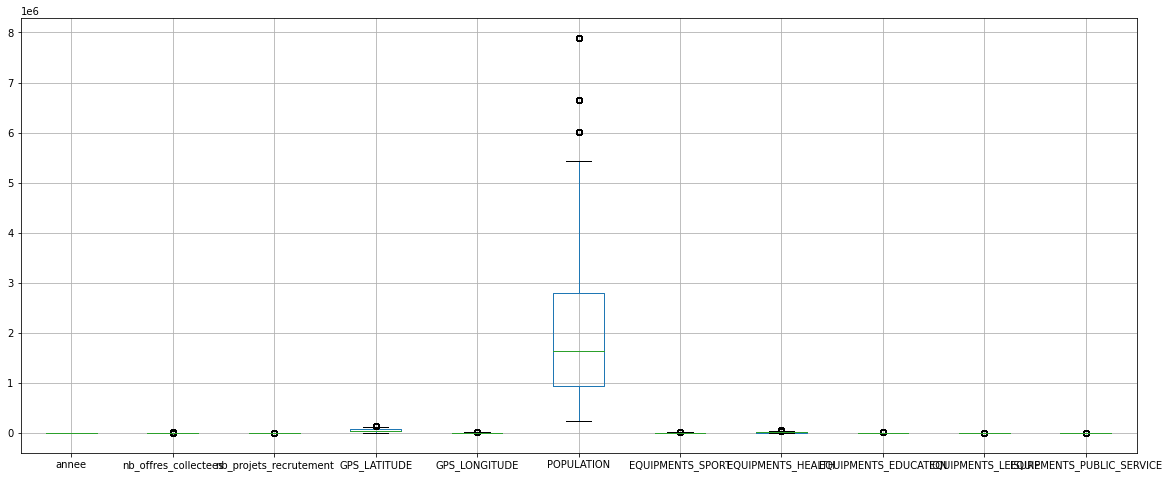

In [208]:
df_merge_3.boxplot(figsize=(20,8))

In [209]:
df_merge_3.columns


Index(['annee', 'metier', 'departement', 'nb_offres_collectees',
       'code_metier_offre', 'code_departement', 'departement_libelle',
       'code_famille_metier', 'libelle_famille_metier',
       'nb_projets_recrutement', 'ID_DEPARTMENT', 'GPS_LATITUDE',
       'GPS_LONGITUDE', 'POPULATION', 'EQUIPMENTS_SPORT', 'EQUIPMENTS_HEALTH',
       'EQUIPMENTS_EDUCATION', 'EQUIPMENTS_LEISURE',
       'EQUIPMENTS_PUBLIC_SERVICE'],
      dtype='object')

<AxesSubplot:>

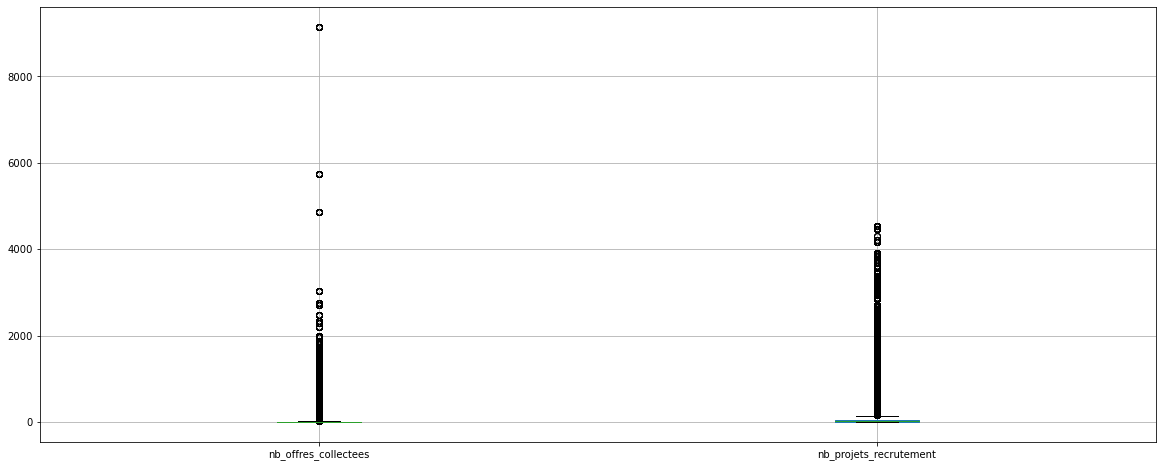

In [212]:
df_merge_3[['metier', 'departement', 'nb_offres_collectees',\
       'code_metier_offre', 'code_departement', 'departement_libelle',\
       'code_famille_metier', 'libelle_famille_metier',\
       'nb_projets_recrutement']].boxplot(figsize=(20,8))

array([[<AxesSubplot:title={'center':'annee'}>,
        <AxesSubplot:title={'center':'nb_offres_collectees'}>,
        <AxesSubplot:title={'center':'nb_projets_recrutement'}>],
       [<AxesSubplot:title={'center':'GPS_LATITUDE'}>,
        <AxesSubplot:title={'center':'GPS_LONGITUDE'}>,
        <AxesSubplot:title={'center':'POPULATION'}>],
       [<AxesSubplot:title={'center':'EQUIPMENTS_SPORT'}>,
        <AxesSubplot:title={'center':'EQUIPMENTS_HEALTH'}>,
        <AxesSubplot:title={'center':'EQUIPMENTS_EDUCATION'}>],
       [<AxesSubplot:title={'center':'EQUIPMENTS_LEISURE'}>,
        <AxesSubplot:title={'center':'EQUIPMENTS_PUBLIC_SERVICE'}>,
        <AxesSubplot:>]], dtype=object)

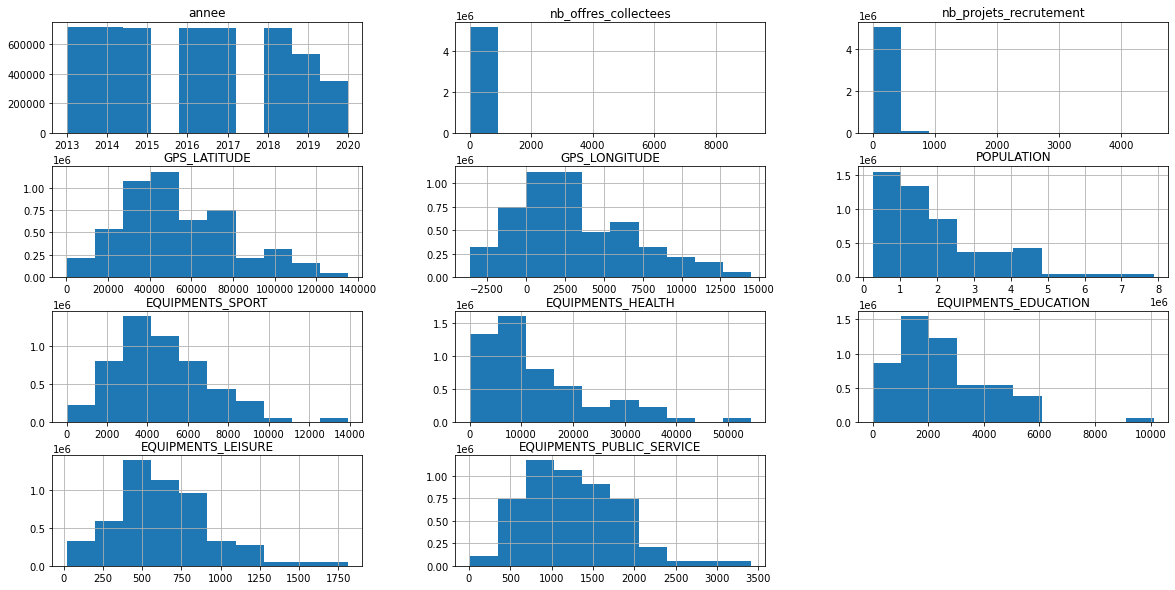

In [215]:
#distribution des variables
df_merge_3.hist(figsize=(20,10))

### Corrélation entre les variables

In [ ]:
scatter_matrix(df_merge_3, alpha=0.2, figsize=(6, 6), diagonal='kde')

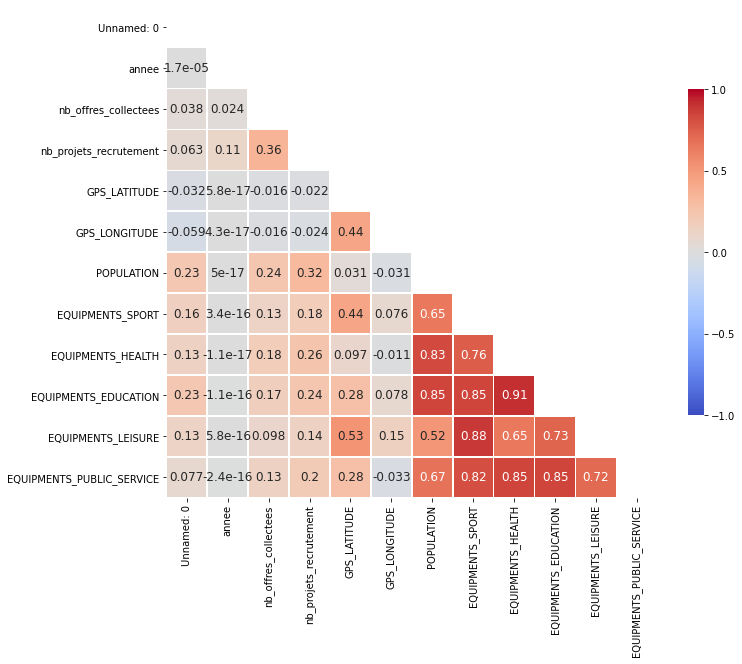

In [13]:
#heatmap
corr_matrix = df_merge_3.corr()
#df_dummy = pd.get_dummies(df_merge_3.htype())
#df_merge_3_corr = pd.concat([df_merge_3, df_dummy], axis = 1)
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

#plot
f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = "coolwarm",
                      cbar_kws = {'shrink': .4,
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Analyse sur la correlation des variable

Nous voyons très faible de correlation entre les autres variables et le nombre d'offres et le nombre de recrutements.



# 4. Analyse Machine Learning

In [30]:
#normalisation des données pour les 2 indicateurs : nb_offres et nb_recrtuement
df_analyse = df_merge_3.copy()




scaler = StandardScaler()

x = df_analyse[["nb_offres_collectees","nb_projets_recrutement"]].values
scaler = scaler.fit(x)
x_scaled  = scaler.transform(x)
#print('Mean: %f, StandardDeviation: %f' % (x_scaled.with_mean, sqrt(scaler.with_std)))
df_analyse[["nb_offres_collectees","nb_projets_recrutement"]] = pd.DataFrame(x_scaled)


<AxesSubplot:>

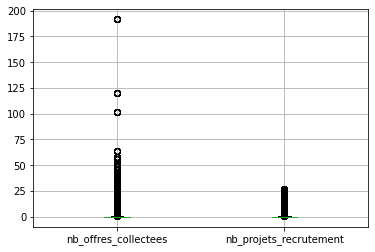

In [31]:

df_analyse[["nb_offres_collectees","nb_projets_recrutement"]].boxplot()

Text(0, 0.5, 'Recrutements')

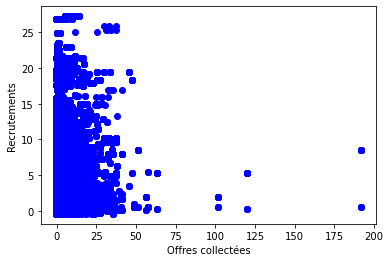

In [35]:
plt.scatter(df_analyse["nb_offres_collectees"], df_analyse["nb_projets_recrutement"], color = 'blue')
plt.xlabel('Offres collectées')
plt.ylabel('Recrutements')


### Application du Kmeans
    . Dans un premier dans il faudrait déterminer le nombre de clusters  choisir

Text(0, 0.5, 'Error Sum of Squares')

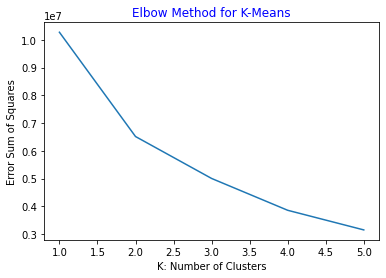

In [64]:
# 1 ere solution en se basant sur l'erreur quadratique
sse=[] #Sum of Squared Errors
for i in range(1,6):
    kmeans = KMeans(i, init='k-means++', random_state=922)
    kmeans.fit(df_analyse[["nb_offres_collectees","nb_projets_recrutement"]])
    sse.append(kmeans.inertia_)
sse

plt.plot(range(1,6), sse, )
plt.title('Elbow Method for K-Means', color = 'blue')
plt.xlabel('K: Number of Clusters')
plt.ylabel('Error Sum of Squares')


In [65]:
#2 methode en se basant sur le coefiscient de silhouette
X=df_analyse[["nb_offres_collectees","nb_projets_recrutement"]]

for num in range(2,4):
    Model = KMeans(num, init='k-means++', random_state= 922)
    kmeans = Model.fit_predict(X)
    score = silhouette_score(X, kmeans)
    values = silhouette_samples(X, kmeans)
    fig = plt.subplots()
    minimum = 0
    for i in range(num):
        SVI = \
            values[kmeans == i] #Silhouette Value of the current number of clusters
        SVI.sort()
        length = SVI.shape[0]
        maximum = minimum + length
        plt.fill_betweenx(np.arange(minimum, maximum), SVI)
        minimum = maximum
    plt.title("The Silhouette Plot with "+str(num)+" Clusters")
    plt.xlabel("Silhouette Score")
    plt.axvline(x=score,color="black")
plt.show()

KeyboardInterrupt: 

In [66]:
for num in range(2,6):
    Model = KMeans(num, init='k-means++')
    kmeans = Model.fit_predict(X)
    print("For "+str(num)+" clusters, the average Silhouette values is equal to", round(silhouette_score(X, kmeans),2))

KeyboardInterrupt: 

In [67]:
# Nb de cluster à choisir
nb_cluster=3

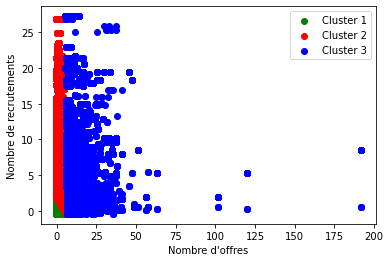

In [74]:
Model = KMeans(nb_cluster, init='k-means++')
k_means= Model.fit_predict(X)

#for i_c in 
plt.scatter(X[k_means == 0]['nb_offres_collectees'], X[k_means == 0]['nb_projets_recrutement'], c = 'green', label = 'Cluster 1')
plt.scatter(X[k_means == 1]['nb_offres_collectees'], X[k_means == 1]['nb_projets_recrutement'], c = 'red', label = 'Cluster 2')
plt.scatter(X[k_means == 2]['nb_offres_collectees'], X[k_means == 2]['nb_projets_recrutement'], c = 'blue', label = 'Cluster 3')
plt.xlabel("Nombre d'offres")
plt.ylabel('Nombre de recrutements')
plt.legend()


# 5. Visualisations